In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Machine Learning - Aufgabenblatt 4

`sklearn` hat auch ein Neural Network Modell (https://scikit-learn.org/stable/modules/neural_networks_supervised.html), in der Praxis werden aber oft ausgereiftere `Deep Learning` Libraries verwendet, wie `tensorflow` (Google) oder `PyTorch` (Facebook).

Darum verwenden wir für diese Aufgabe `tensorflow` und nicht `sklearn`.

In [34]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

# random seed fixieren für Musterlösung 
tf.random.set_seed(42)

Damit wir Dinge von den vorherigen Aufgabenblätter nicht zu fest wiederholen, haben wir hier bereits den `Datensatz` und eine `Baseline` vorbereitet.

## Datensatz - MNIST

Wir können den Datensatz über `sklearn.datasets.fetch_openml` laden.

In [35]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(np.int32) # Cast string like '1' to integer like 1.

/Users/mebr/PycharmProjects/cas_machine-learning-exercise/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Wir skalieren die Pixelwerte zwischen 0 und 1 (anstatt 0 und 255). Dies ist wichtig für das `Gradient Descent` Lernverfahren.

In [36]:
print("Vorher:", X.max())
X = X / 255  # Sehr einfaches skalieren (oft aussreichend für Bilder)
print("Nach einfachem Skalieren:", X.max())

Vorher: 255.0
Nach einfachem Skalieren: 1.0


Anschliessend teilen wir die Daten wieder in `Train-Set`, `Validation-Set` und `Test-Set`.

In [37]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=5_000, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=5_000, stratify=y_data, random_state=42)

Und wir schauen uns Beispiele dieser handgeschriebenen Zahlen vom `Data-Set` an.

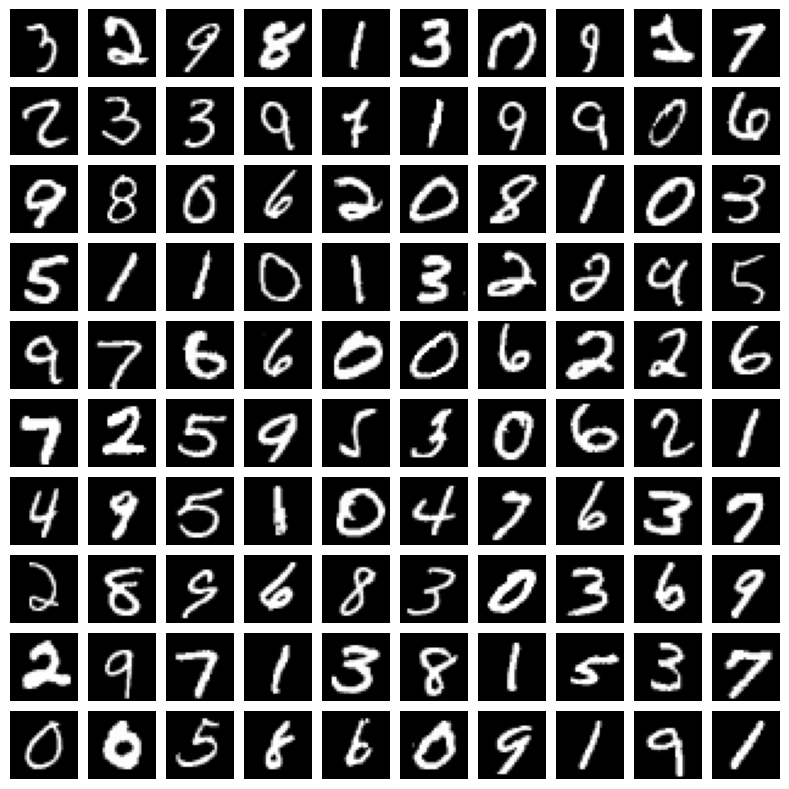

In [38]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))

grid = ImageGrid(fig, 111,  # similar to subplot(111)
    nrows_ncols=(10, 10),  # creates 2x2 grid of axes
    axes_pad=0.1,  # pad between axes in inch.
)

for ax, im in zip(grid, X_data.reshape(-1, 28, 28)):
    ax.axis('off')
    ax.imshow(im, cmap='gray')

plt.show()

Wie es bei der `Classification` eigentlich immer Sinn gibt, schauen wir uns die Verteilung der Zielvariable an:

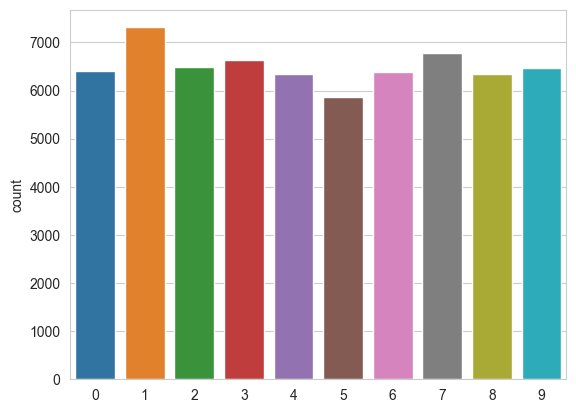

In [39]:
sns.countplot(x=y_data)
plt.show()

Und sehen, dass wir in etwa gleich viele Datenpunkt pro Klasse haben.

## Aufgabe 1 - Logistische Regression als Neural Network

In Aufgabe 1 bauen wir die `Logistische Regression` (die `Baseline` aus der Aufgabenbeschreibung) als `Neurales Netzwerk` nach. Anschliessend trainieren und evaluieren wir das Netzwerk.

Dieses `Neurales Netzwerk` hat noch keinen `Hidden Layer` und ist dadurch ein lineares Modell. Es entspricht (bis auf wie es trainiert wird) der `Logistischen Regression` von `sklearn` und wir erwarten daher in Aufgabe 1 (noch) keine Verbesserung zur `Baseline`.

In der Aufgabe 2 schauen wir uns dann ein `Neurales Netz` mit einem `Hidden Layer` mit nicht linearer Aktivierungsfunktion an - ein nicht lineares Modell.

### Aufgabe 1.1 - Logistische Regression als (Feed Forward) Neural Network

1. Erstellen Sie ein sequenzielles Neurales Netzwerk mittels `tf.keras.Sequential`
2. Fügen Sie einen Input Layer `tf.keras.layers.InputLayer` mit der shape `input_shape=(28*28,)` hinzu mittels `model.add`.
3. Fügen Sie einen Output Layer `tf.keras.layers.Dense` mit `units=10` und der Softmax Aktivierungsfunktion `activation=tf.keras.activations.softmax` hinzu mittels `model.add`.
4. Geben Sie eine Beschreibung des Modell mittels `print(model.summary())` aus. Das Modell sollte 7850 totale Parameter haben.
5. (Extra) Rechnen Sie die Anzahl Parameter von Hand nach.

Zur Illustration ist das Neurale Netzwerk von Aufgabe 1 hier grafisch abgebildet. Es hat 784 Inputs ($x_1$, ..., $x_{784}$) für jeden Pixel ein Input (28 * 28 = 784) und 10 Ouputs ($\hat y_0$, ..., $\hat y_9$) für jede `Klasse` (Ziffer) einen Output.

![Logistische Regression als Neural Network](./img/logistic-regression-as-nn-mnist.png)


#### Hilfreiche Links

* tf.keras.Sequential: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

In [40]:
import tensorflow as tf

# Neural Network ohne Hidden Layer
# 1.
model = tf.keras.Sequential()
# 2. 
model.add(tf.keras.layers.InputLayer(input_shape=(28*28,), name='input_layer'))
# 3.
model.add(tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name='output_layer'))

# 4.
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output_layer (Dense)        (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
None


5\.
Wir haben für jeden Input ($x_1$ bis $x_{784}$) und für den Bias ($x_0$) jeweils einen Verbindung (Pfeil) zu jedem Output ($\hat y_0$ bis $\hat y_9$).
Für jede Verbindung haben wird ein Parameter (Gewicht): 
$\text{Anzahl Verbindungen} = (\text{Inputs} + \text{Bias}) * \text{Ouputs} = (784 + 1) * 10 = 7850 = \text{Total Parameter} $

### Aufgabe 1.2 - `model.compile`, `model.fit`

In Aufgabe 1.1 haben wir das Netzwerk erstellt und mit `model.summary()` überprüft.

Nun möchten wir das Modell trainieren (`fit`).

Dazu müssen wir dem Modell mitteilen, welches Optimierungsverfahren (`optimizer`) und welche Kostenfunktion (`loss`) wir für das Training verwenden möchten.

In der `Logistischen Regression` von `sklearn` sind diese Werte im Modell hard-codiert vorgegeben und man kann sie nicht überschreiben. 
`Neurale Netze` von `tensorflow` können mit unterschiedlichen Kostenfunktionen (`tf.keras.losses`) und unterschiedlichen Optimiertungsverfahren (z.B. `adam`) trainiert werden. Darum muss man diese Werte für ein `tensorflow` Modell noch angeben.

1. Erstellen Sie eine `tf.keras.losses.SparseCategoricalCrossentropy` Funktion mit `from_logits=False`.
2. Kompilieren Sie das Modell mit `model.compile`. Geben Sie die `loss` Funktion und den `optimizer` an. Für den `optimizer` können Sie `sgd` für das `Batch Gradient Descent` Verfahren oder `adam` für `Adam` ein verbessertes `Batch Gradient Descent` Verfahren.
3. Trainieren Sie das Modell mittels `model.fit`. Wir müssen eine Batch Size `batch_size=64` und die Anzahl Epochen `epochs=15` mitgeben:
    - `batch_size`: Wie viele Datenpunkte werden für einen Schritt im `Batch Gradient Descent` Verfahren verwendet.
    - `epochs`: Wie oft iterieren wir über das gesamte `Train-Set`.
4. Berechnen Sie die Wahrscheinlichkeiten der Klassen `y_val_hat_prob` auf dem `Validation-Set` (`X_val`) mittels `model.predict`.
    - Anders als die Logistische Regression gibt uns `model.predict` hier 10 Outputs, **die Wahrscheinlichkeiten** für jede `Klasse`.
5. Holen Sie die tatsächliche Vorhersagen `y_val_hat` aus den Wahrscheinlichkeiten `y_val_hat_prob` aus Schritt 2. Die tatsächliche Vorhersage ist der Output mit dem grössten Wert (der grösste Wahrscheinlichkeit).
    - Nutzen Sie dazu `np.argmax` über die zweite Achse `axis=1`.
    - Geben Sie die `shape` von `y_val_hat_prob` und von `y_val_hat` aus, um besser zu verstehen, was wir genau machen.
6. Berechnen Sie die Genauigkeit unseres Modelles mittels `accuracy_score`.
7. Berechnen Sie die Confusion Matrix mittels `confusion_matrix`.

In [41]:
# 1.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# 2.
model.compile(
    optimizer='adam', # adam ist eine Form von Stochastic Gradient Descent mit extra Schritten, damit das Netzwerk schneller lernt.
    loss=loss_fn,    
    metrics=['accuracy'] # Metrik können für das Ausgeben von zwischen Ergebnissen angegeben werden
)

In [42]:
# 3. Wir speichern noch die `fit`-history, um sie in anschliessend zu plotten.
history = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
938/938 [==============================] - 1s 598us/step - loss: 0.5482 - accuracy: 0.8630 - val_loss: 0.3538 - val_accuracy: 0.9048
Epoch 2/15
938/938 [==============================] - 0s 495us/step - loss: 0.3225 - accuracy: 0.9110 - val_loss: 0.3119 - val_accuracy: 0.9140
Epoch 3/15
938/938 [==============================] - 1s 590us/step - loss: 0.2950 - accuracy: 0.9173 - val_loss: 0.2960 - val_accuracy: 0.9182
Epoch 4/15
938/938 [==============================] - 1s 597us/step - loss: 0.2810 - accuracy: 0.9215 - val_loss: 0.2872 - val_accuracy: 0.9216
Epoch 5/15
938/938 [==============================] - 1s 558us/step - loss: 0.2726 - accuracy: 0.9238 - val_loss: 0.2877 - val_accuracy: 0.9218
Epoch 6/15
938/938 [==============================] - 0s 512us/step - loss: 0.2666 - accuracy: 0.9256 - val_loss: 0.2832 - val_accuracy: 0.9262
Epoch 7/15
938/938 [==============================] - 0s 529us/step - loss: 0.2626 - accuracy: 0.9265 - val_loss: 0.2785 - val_accuracy:

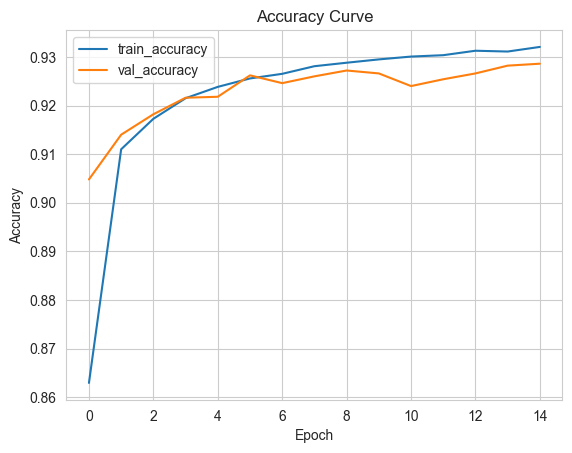

In [43]:
# Plotten der History: Zeigt den Verlauf des Trainings über die Anzahl Epochen. (Nicht Teil der Aufgabe)
# Hierfür muss bei `model.compile` di `accuracy` Metrik und bei fit das `Validation-Set` mitgegeben worden sein.
plt.title('Accuracy Curve')
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [44]:
# 4.
y_val_hat_prob = model.predict(X_val)
# 5.
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print("y_val_hat_prob.shape: ", y_val_hat_prob.shape)
print("y_val_hat.shape: ", y_val_hat.shape)

# 6.
print(accuracy_score(y_val_hat, y_val))

157/157 [==============================] - 0s 316us/step
y_val_hat_prob.shape:  (5000, 10)
y_val_hat.shape:  (5000,)
0.9286


Die `Accuracy` unseres `Neuralen Netzwerkes` **ohne** `Hidden Layer` entspricht in etwa der Performanz der `Logistischen Regression`, was, wie oben beschrieben, zu erwarten war. 

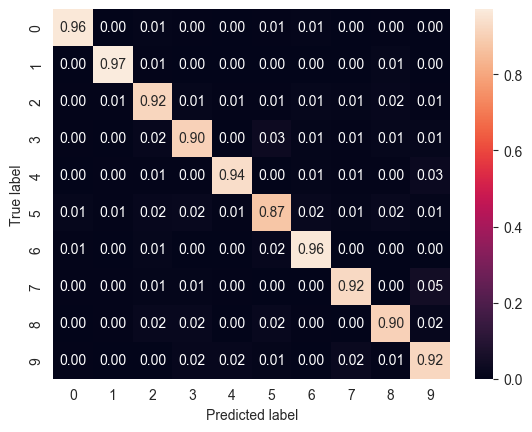

In [45]:
# 7.
sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_val_hat, normalize="true"),
    ),
    annot=True, # Show numbers in heatmap (not just colors
    fmt=".2f", # Format numbers to 2 decimal places
)
plt.ylabel('True label') # Name y-axis
plt.xlabel('Predicted label') # Name x-axis
plt.show()

### Schlusswort Aufgabe 1

In der Aufgabe 1 haben wir eine `Logistische Regression` als `Neurales Netzwerk` "nachgebaut", trainiert und evaluiert.

Wir haben dafür `tensorflow` kennengelernt und können in Aufgabe 2 unser neues Wissen nutzen und ein `Neurales Netz` mit einem `Hidden Layer` entwickeln.

### Aufgabe 2

#### Aufgabe 2.1 - (Feed-Forward) Neural Network mit einem Hidden Layer

Ziel dieser Aufgabe ist es folgendes Neurales Netzwerk zu bauen:

![One-Hidden-Layer (mit 36 Neuronen) Neural Network für MNIST](./img/nn-one-hidden-mnist.png)

1. Erstellen Sie das dargestellte Neurale Netzwerk. Achten Sie darauf, dass der `Hidden Layer` eine `Aktivierungsfunktion` mittels dem Parameter `activation` benötigt. Verwenden Sie `tf.keras.activations.relu` oder `tf.keras.activations.gelu`. Der Hidden Layer hat 36 Neuronen `units=36`. In der Praxis nimmt man eher eine Zweierpotzent wie 32, 64 oder 128 (aus Performanzgründen).
2. Geben Sie eine Beschreibung des Modell mittels `print(model.summary())` aus. Das Modell sollte **28'630 totale Parameter** haben.
3. Kompilieren Sie das Modell analog zur Aufgabe 1.
4. Trainieren Sie das Modell auf dem `Train-Set`.
5. Evaluieren Sie das Modell auf dem `Validation-Set`.

In [46]:
# 1. Neural Network mit einem Hidden Layer
model_with_hl = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28*28,), name='input_layer'),
    tf.keras.layers.Dense(36, activation=tf.keras.activations.gelu, name='hidden_layer'),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name='output_layer'),
    tf.keras.layers.Softmax()
])

# 2. 
print(model_with_hl.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer (Dense)        (None, 36)                28260     
                                                                 
 output_layer (Dense)        (None, 10)                370       
                                                                 
 softmax_2 (Softmax)         (None, 10)                0         
                                                                 
Total params: 28,630
Trainable params: 28,630
Non-trainable params: 0
_________________________________________________________________
None


In [47]:
# 3.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

model_with_hl.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

In [48]:
# 4.
history = model_with_hl.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_val, y_val))

Epoch 1/15
938/938 [==============================] - 1s 848us/step - loss: 1.6193 - accuracy: 0.8752 - val_loss: 1.5524 - val_accuracy: 0.9226
Epoch 2/15
938/938 [==============================] - 1s 740us/step - loss: 1.5412 - accuracy: 0.9301 - val_loss: 1.5389 - val_accuracy: 0.9306
Epoch 3/15
938/938 [==============================] - 1s 715us/step - loss: 1.5277 - accuracy: 0.9412 - val_loss: 1.5265 - val_accuracy: 0.9396
Epoch 4/15
938/938 [==============================] - 1s 710us/step - loss: 1.5188 - accuracy: 0.9482 - val_loss: 1.5218 - val_accuracy: 0.9442
Epoch 5/15
938/938 [==============================] - 1s 702us/step - loss: 1.5120 - accuracy: 0.9550 - val_loss: 1.5165 - val_accuracy: 0.9508
Epoch 6/15
938/938 [==============================] - 1s 656us/step - loss: 1.5077 - accuracy: 0.9587 - val_loss: 1.5140 - val_accuracy: 0.9512
Epoch 7/15
938/938 [==============================] - 1s 650us/step - loss: 1.5036 - accuracy: 0.9619 - val_loss: 1.5107 - val_accuracy:

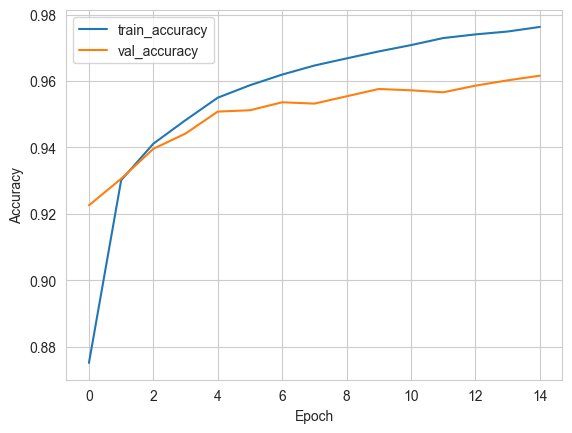

In [49]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
# 5.
y_val_hat_prob = model_with_hl.predict(X_val)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val))

157/157 [==============================] - 0s 329us/step
0.9616


Es kam mit einer Genauigkeit von 95% zu einer Verbesserung gegenüber Aufgabe 1, wo wir eine Genauigkeit von 92% erzielten.

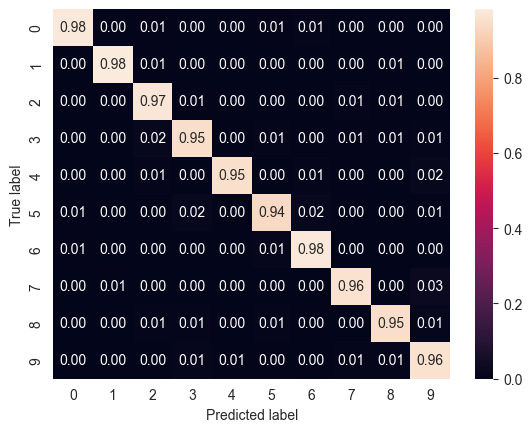

In [51]:
from sklearn.metrics import confusion_matrix

sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_val_hat, normalize="true"),
    ),
    annot=True, # Show numbers in heatmap (not just colors
    fmt=".2f", # Format numbers to 2 decimal places
)
plt.ylabel('True label') # Name y-axis
plt.xlabel('Predicted label') # Name x-axis
plt.show()

## (Extra) Aufgabe 3 - CNN

Mit Bildern werden im Deep Learning oft `Convolutional Neural Networks` (`CNN`) eingesetzt.

CNNs sind laut Drehbuch nicht Teil vom Inhalt von diesem Modul, für interessierte zeigt diese Aufgabe wie man sie einsetzt.  

Anders als beim Feed-Forward Neural Network (Aufgabe 2) legen wir nicht Masken über den gesamten Input sondern legen eine kleine Maske (z.B. 3*3 Pixel) und sliden diese über das gesamte Bild. Die Output-Werte dieses Verfahrens sind dann die Aktivierungen (Features) dieser Maske an den verschiedenen Stellen im Bild. 

Mehr zu CNNs finden Sie hier: https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939

1. Machen Sie ein Modell mit `tf.keras.layers.Conv2D` Layers.

In [52]:
# Neural Network mit zwei Hidden Convolution Layers
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(28, 28, 1), name='input_layer'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation=tf.keras.activations.gelu, name='hidden_layer_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation=tf.keras.activations.gelu, name='hidden_layer_2'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax, name='output_layer'),
    tf.keras.layers.Softmax()
])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Conv2D)     (None, 13, 13, 32)        320       
                                                                 
 hidden_layer_2 (Conv2D)     (None, 6, 6, 32)          9248      
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 output_layer (Dense)        (None, 10)                11530     
                                                                 
 softmax_3 (Softmax)         (None, 10)                0         
                                                                 
Total params: 21,098
Trainable params: 21,098
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [54]:
model.compile(
    optimizer='adam',
    loss=loss_fn,
    metrics=['accuracy']
)

In [55]:
"""
Without GPU (or TPU :D) support, this may take a while.
Convolutions on CPUs (in tensorflow) are quit slow.
Note that this model has less total parameters than Aufgabe 2.
"""

X_train_sq = X_train.reshape(-1, 28, 28, 1)
X_val_sq = X_val.reshape(-1, 28, 28, 1)

history = model.fit(X_train_sq, y_train, batch_size=128, epochs=15, validation_data=(X_val_sq, y_val))

Epoch 1/15
  1/469 [..............................] - ETA: 1:29 - loss: 2.3027 - accuracy: 0.1172

/Users/mebr/PycharmProjects/cas_machine-learning-exercise/venv/lib/python3.8/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 [==============================] - 4s 7ms/step - loss: 1.6593 - accuracy: 0.8258 - val_loss: 1.5272 - val_accuracy: 0.9376
Epoch 2/15
469/469 [==============================] - 3s 7ms/step - loss: 1.5168 - accuracy: 0.9473 - val_loss: 1.5063 - val_accuracy: 0.9564
Epoch 3/15
469/469 [==============================] - 3s 7ms/step - loss: 1.4988 - accuracy: 0.9646 - val_loss: 1.4953 - val_accuracy: 0.9682
Epoch 4/15
469/469 [==============================] - 3s 7ms/step - loss: 1.4909 - accuracy: 0.9716 - val_loss: 1.4902 - val_accuracy: 0.9722
Epoch 5/15
469/469 [==============================] - 3s 7ms/step - loss: 1.4867 - accuracy: 0.9757 - val_loss: 1.4876 - val_accuracy: 0.9742
Epoch 6/15
469/469 [==============================] - 3s 7ms/step - loss: 1.4839 - accuracy: 0.9787 - val_loss: 1.4863 - val_accuracy: 0.9754
Epoch 7/15
469/469 [==============================] - 3s 7ms/step - loss: 1.4816 - accuracy: 0.9803 - val_loss: 1.4832 - val_accuracy: 0.9796
Epoch 8/15
469/46

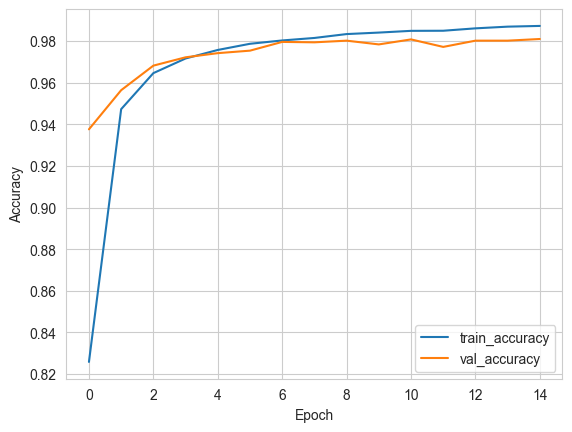

In [56]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
y_val_hat_prob = model.predict(X_val_sq)
y_val_hat = np.argmax(y_val_hat_prob, axis=1)

print(accuracy_score(y_val_hat, y_val))

157/157 [==============================] - 0s 1ms/step
0.981


Wir erreichen eine höhere Genauigkeit als in Aufgabe 2, haben aber weniger Parameter als in Aufgabe 2 im Neuralen Netz. Durch die andere Struktur des Netzwerkes nutzen wir die Parameter besser für den Bild-Task.

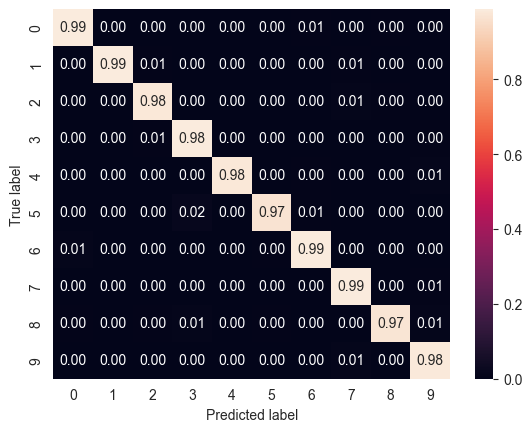

In [58]:
from sklearn.metrics import confusion_matrix

sns.heatmap(
    pd.DataFrame(
        confusion_matrix(y_true=y_val, y_pred=y_val_hat, normalize="true"),
    ),
    annot=True, # Show numbers in heatmap (not just colors
    fmt=".2f", # Format numbers to 2 decimal places
)
plt.ylabel('True label') # Name y-axis
plt.xlabel('Predicted label') # Name x-axis
plt.show()


## Schlusswort Aufgabenblatt 4

In diesem Aufgabenblatt haben wir uns mit dem Thema `Deep Learning` beschäftigt. Wir haben uns mit den Grundlagen von Neural Networks beschäftigt und diese auf den MNIST Datensatz angewendet.